# ***Import Libraries***

In [526]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


# ***Download NLTK Resources***

In [527]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# ***Explore the Dataset***

In [528]:
df = pd.read_csv('spam_ham_dataset.csv')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


# ***Data Cleaning***

In [529]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [530]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5171 non-null   object
 1   text       5171 non-null   object
 2   label_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [531]:
df.duplicated().sum()

np.int64(178)

In [532]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4993 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      4993 non-null   object
 1   text       4993 non-null   object
 2   label_num  4993 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 156.0+ KB


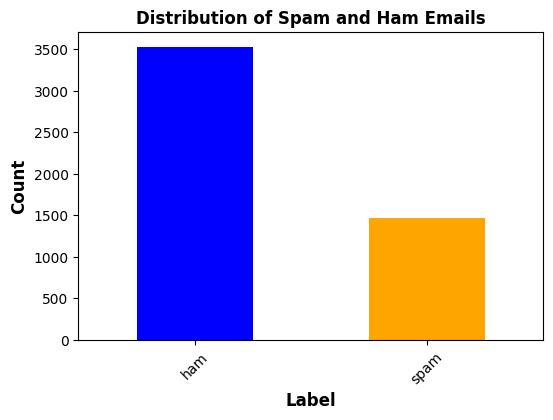

In [533]:
plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Spam and Ham Emails', fontsize=12, fontweight='bold')
plt.xlabel('Label', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.show()

In [534]:
df.drop(columns=['label'], inplace=True)

# ***Text Preprocessing***

In [535]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords]
    return ' '.join(tokens)


In [536]:
df.text.iloc[0]

"Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nactivity you can obtain from gas control .\r\nthis change is needed asap for economics purposes ."

In [537]:
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [538]:
df["cleaned_text"].iloc[0]

'subject enron methanol meter 988291 follow note gave monday 4 3 00 preliminary flow data provided daren please override pop daily volume presently zero reflect daily activity obtain gas control change needed asap economics purpose'

# ***Feature Extraction***

In [539]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['cleaned_text']).toarray()
y = df["label_num"]

# ***Splitting the Data***

In [540]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ***Multinimial Naive Bayes Model***

In [541]:
NBmodel = MultinomialNB()
NBmodel.fit(X_train, y_train)

MultinomialNB()

In [542]:
y_pred_NB = NBmodel.predict(X_test)


## ***Model Evaluation***

In [543]:
accuracy_NB = accuracy_score(y_test, y_pred_NB)
print(f'Accuracy: {accuracy_NB:.2f}')

Accuracy: 0.98


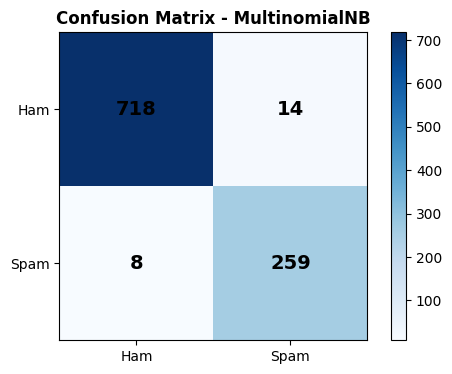

In [544]:
plt.figure(figsize=(6,4))
confusion_matrix_NB = confusion_matrix(y_test, y_pred_NB)
plt.imshow(confusion_matrix_NB, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - MultinomialNB', fontsize=12, fontweight='bold')
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
plt.yticks(ticks=[0, 1], labels=['Ham', 'Spam'])

# Add counts inside the boxes
for i in range(confusion_matrix_NB.shape[0]):
    for j in range(confusion_matrix_NB.shape[1]):
        plt.text(j, i, str(confusion_matrix_NB[i, j]),
                 ha='center', va='center', color='black', fontsize=14, fontweight='bold')

plt.show()

In [545]:
class_report_NB=classification_report(y_test, y_pred_NB)
print('Classification Report:\n',class_report_NB)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       732
           1       0.95      0.97      0.96       267

    accuracy                           0.98       999
   macro avg       0.97      0.98      0.97       999
weighted avg       0.98      0.98      0.98       999



## ***Testing The Model With New Samples***

In [546]:
sample_text1 = "Hi, just wanted to check in and see how you're doing. Let me know if you need anything."
sample_cleaned = preprocess_text(sample_text1)
sample_vector = vectorizer.transform([sample_cleaned]).toarray()
sample_pred = NBmodel.predict(sample_vector)
print("Prediction:", "Spam" if sample_pred[0] == 1 else "Ham")

Prediction: Ham


In [547]:
sample_text2 = "Congratulations! You've won a free prize. Click here to claim."
sample_cleaned = preprocess_text(sample_text2)
sample_vector = vectorizer.transform([sample_cleaned]).toarray()
sample_pred = NBmodel.predict(sample_vector)
print("Prediction:", "Spam" if sample_pred[0] == 1 else "Ham")

Prediction: Spam


In [548]:
sample_text3 = (
    "Hello team,\n\n"
    "I hope this message finds you well. I wanted to remind everyone about our meeting scheduled for tomorrow at 10 AM. "
    "Please bring the latest project updates and any questions you might have. "
    "Let me know if you are unable to attend or need any assistance with your tasks.\n\n"
    "Best regards,\nAbdelrahman"
)
sample_cleaned = preprocess_text(sample_text3)
sample_vector = vectorizer.transform([sample_cleaned]).toarray()
sample_pred = NBmodel.predict(sample_vector)
print("Prediction:", "Spam" if sample_pred[0] == 1 else "Ham")

Prediction: Ham


In [549]:
sample_text4 = (
    "Attention: Your account will be suspended unless you verify your information immediately. "
    "Click the link below to avoid interruption of service. "
    "If you have questions, contact support. "
    "Thank you for being a valued customer."
)
sample_cleaned = preprocess_text(sample_text4)
sample_vector = vectorizer.transform([sample_cleaned]).toarray()
sample_pred = NBmodel.predict(sample_vector)
print("Prediction:", "Spam" if sample_pred[0] == 1 else "Ham")

Prediction: Ham


# ***Random Forest Classifier Model***

In [550]:
rfc=RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1)

In [551]:
y_pred_rfc=rfc.predict(X_test)

## ***Model Evaluation***

In [552]:
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
print(f'Accuracy: {accuracy_rfc:.2f}')

Accuracy: 0.98


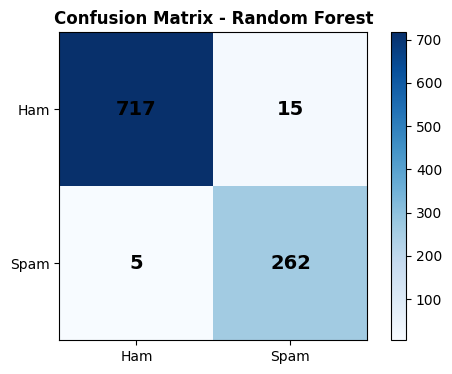

In [553]:
plt.figure(figsize=(6,4))
confusion_matrix_rfc = confusion_matrix(y_test, y_pred_rfc)
plt.imshow(confusion_matrix_rfc, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest', fontsize=12, fontweight='bold')
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
plt.yticks(ticks=[0, 1], labels=['Ham', 'Spam'])
for i in range(confusion_matrix_rfc.shape[0]):
    for j in range(confusion_matrix_rfc.shape[1]):
        plt.text(j, i, str(confusion_matrix_rfc[i, j]),
                 ha='center', va='center', color='black', fontsize=14, fontweight='bold')

plt.show()

In [554]:
class_report_rfc=classification_report(y_test, y_pred_rfc)
print('Classification Report:\n',class_report_rfc)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       732
           1       0.95      0.98      0.96       267

    accuracy                           0.98       999
   macro avg       0.97      0.98      0.97       999
weighted avg       0.98      0.98      0.98       999



## ***Testing The Model With New Samples***

In [555]:
sample_text5 = "Hi, just wanted to check in and see how you're doing. Let me know if you need anything."
sample_cleaned = preprocess_text(sample_text5)
sample_vector = vectorizer.transform([sample_cleaned]).toarray()
sample_pred = rfc.predict(sample_vector)
print("Prediction:", "Spam" if sample_pred[0] == 1 else "Ham")

Prediction: Ham


In [556]:
sample_text6 = "Congratulations! You've won a free prize. Click here to claim."
sample_cleaned = preprocess_text(sample_text6)
sample_vector = vectorizer.transform([sample_cleaned]).toarray()
sample_pred = rfc.predict(sample_vector)
print("Prediction:", "Spam" if sample_pred[0] == 1 else "Ham")

Prediction: Spam


In [557]:
sample_text7 = (
    "Hello team,\n\n"
    "I hope this message finds you well. I wanted to remind everyone about our meeting scheduled for tomorrow at 10 AM. "
    "Please bring the latest project updates and any questions you might have. "
    "Let me know if you are unable to attend or need any assistance with your tasks.\n\n"
    "Best regards,\nAbdelrahman"
)
sample_cleaned = preprocess_text(sample_text7)
sample_vector = vectorizer.transform([sample_cleaned]).toarray()
sample_pred = rfc.predict(sample_vector)
print("Prediction:", "Spam" if sample_pred[0] == 1 else "Ham")

Prediction: Ham


In [558]:
sample_text8 = (
    "Attention: Your account will be suspended unless you verify your credit information immediately. "
    "Click the link below to avoid interruption of service. "
    "If you have questions, contact support. "
    "Thank you for being a valued customer."
)
sample_cleaned = preprocess_text(sample_text8)
sample_vector = vectorizer.transform([sample_cleaned]).toarray()
sample_pred = rfc.predict(sample_vector)
print("Prediction:", "Spam" if sample_pred[0] == 1 else "Ham")

Prediction: Spam


## **Conclusion**

In this notebook, we built and evaluated two machine learning models—**Multinomial Naive Bayes (MNB)** and **Random Forest Classifier (RFC)**—for email spam detection. The workflow included data cleaning, text preprocessing (tokenization, lemmatization, and stopword removal), feature extraction using bag-of-words, and model training and evaluation. We visualized the performance of both models using confusion matrices and classification reports.

To further assess the models, we tested them on four new email samples, including both clear and ambiguous cases of spam and ham. The results showed:

- **Multinomial Naive Bayes (MNB)** correctly classified **3 out of 4** new samples.
- **Random Forest Classifier (RFC)** correctly classified **all 4 out of 4** new samples.

**Comparison:**  
While both models performed well on the test set, the RFC model demonstrated slightly better generalization to new, unseen samples, especially for more ambiguous cases. This suggests that RFC may be more robust for real-world spam detection tasks, though MNB remains a strong and efficient baseline for text classification problems.